In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import random
import seaborn as sns
pd.options.display.max_rows=300
pd.set_option('display.max_columns', None)

In [ ]:
df_type = pd.read_csv("../../01.MIMICIV_SAKI_trajCluster/df_mixAK_fea4_C3.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("Number of included patients:",len(all_lst))

df_type_filt_count = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
df_type_filt_count.columns = ["groupHPD","count_all"]
df_type_filt_count

In [3]:
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
df_time = df_time[["stay_id","sepsis_onset", "saki_onset"]]
df_time = pd.merge(df_type_filt, df_time, how="inner", on="stay_id")
df_time["sepsis_onset"] = pd.to_datetime(df_time["sepsis_onset"])
df_time["saki_onset"] = pd.to_datetime(df_time["saki_onset"])
df_time.head(2)

,stay_id,groupHPD,sepsis_onset,saki_onset
0,30003598,1,2189-04-14 21:00:00,2189-04-15 03:04:00
1,30004144,2,2126-04-05 00:00:00,2126-04-05 06:00:00


# input data

## weight

In [ ]:
#  the weight in the uo table
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v2/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
df_time = df_time[["stay_id", "saki_onset"]]
df_time["saki_onset"] = pd.to_datetime(df_time["saki_onset"])

df_demo = pd.read_csv("../../00.data_mimic/disease_definition/AKI/kdigo_uo.csv") #pd.read_csv("../../00.data_mimic/feature_data/icu_basicinfo.csv")
df_demo = df_demo[["stay_id","charttime","weight"]]
df_demo = df_demo[df_demo["stay_id"].isin(all_lst)].drop_duplicates()
df_demo["charttime"] = pd.to_datetime(df_demo["charttime"], format='%d/%m/%Y %H:%M:%S')
df_demo = pd.merge(df_demo, df_time, how="inner",on="stay_id")
df_demo["time"] = (df_demo["charttime"] - df_demo["saki_onset"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()

df_demo["time"]=round(df_demo["time"],0)
df_demo = df_demo[["stay_id","weight","time"]].drop_duplicates()
df_demo["time"] = df_demo["time"].map(lambda x: -1*x if x<0 else x)
df_demo = df_demo.sort_values(["stay_id","time"])
df_demo = df_demo.groupby(["stay_id"]).head(1)[["stay_id","weight"]]
df_demo["weight"].fillna(df_demo["weight"].mean(), inplace=True)
df_weight = df_demo
df_weight.head(1)

,stay_id,weight
6,30003598,136.0


## Diuretic
- Unit conversion

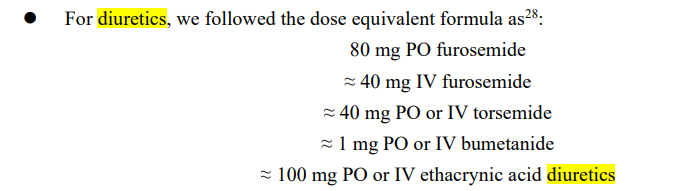

In [ ]:
# 220987	D-Mannitol (C6H14O6)
# 220988	Mannitol 5%
# 220989	Mannitol 10%
# 220990	Mannitol 15%
# 220991	Mannitol 20%
# 220992	Mannitol 25%

# 227531	Mannitol
# 221794	Furosemide (Lasix)
# 228340	Furosemide (Lasix) 250/50
# 229639	Bumetanide (Bumex)

df_di = pd.read_csv("../../00.data_mimic/treatment//diuretic.csv")
df_di = df_di[df_di.stay_id.isin(all_lst)]
df_di = df_di[(df_di.amountuom != "dose") & (df_di.itemid != 227531)]
df_di = df_di[['stay_id', 'starttime', 'endtime','amount', 'amountuom',"itemid","ordercategoryname"]]
df_di["starttime"] = pd.to_datetime(df_di["starttime"] )
df_di["endtime"] = pd.to_datetime(df_di["endtime"])
print(df_di.itemid.value_counts())
df_di.loc[df_di["itemid"]==229639,"amount"] *= 80
df_di.loc[df_di["ordercategoryname"]=='01-Drips',"amount"]  *= 2
df_di.loc[df_di["ordercategoryname"]=='05-Med Bolus',"amount"]  *= 1
df_di = df_di[['stay_id', 'starttime', 'endtime','amount']] # mg to mg PO furosemide
df_di.loc[df_di["amount"]>df_di["amount"].quantile(0.99),"amount"] = 0 # df_di["amount"].quantile(0.99) = 774

221794    18727
228340     2666
229639      157
Name: itemid, dtype: int64


In [6]:
import datetime
def dateHourRange(beginDateHour, endDateHour):
    beginDateHour= beginDateHour.strftime('%Y-%m-%d %H:%M:%S')
    endDateHour= endDateHour.strftime('%Y-%m-%d %H:%M:%S')
    dhours = []
    dhour = datetime.datetime.strptime(beginDateHour, "%Y-%m-%d %H:%M:%S")
    date = beginDateHour[:]
    while date <= endDateHour:
        dhours.append(date)
        dhour = dhour + datetime.timedelta(hours=1)
        date = dhour.strftime("%Y-%m-%d %H:%M:%S")
    return dhours

tem_di = df_di
tem_di["time_lst"] = tem_di.apply(lambda x: dateHourRange(x['starttime'],x['endtime']),axis=1)
tem_di["time_num"] = tem_di["time_lst"].map(lambda x: len(x))
tem_di["amount_hourly"] =  tem_di["amount"]/tem_di["time_num"] 

tem_di['idx'] = range(len(tem_di))
tem_add = tem_di.set_index('idx').time_lst.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'charttime'})
tem_di_hourly = pd.merge(tem_di, tem_add,how="inner", on="idx")
tem_di_hourly = tem_di_hourly.loc[:,['stay_id', 'charttime',  'amount_hourly']] # 'starttime', 'endtime', 'amount',
tem_di_hourly = tem_di_hourly.rename(columns={"amount_hourly":"amount"})
tem_di_hourly["charttime"] = pd.to_datetime(tem_di_hourly["charttime"] )
tem_di_hourly.head(2)

,stay_id,charttime,amount
0,36753294,2141-05-23 03:33:00,40.000003
1,36753294,2141-05-23 19:50:00,40.000003


In [ ]:
# 24h hour window 
df_di = tem_di_hourly
df_di = df_di[df_di["stay_id"].isin(all_lst)]
df_time_cut = df_time[['stay_id', 'saki_onset']]
df_di = pd.merge(df_di,df_time_cut, how="right",on="stay_id")

df_di["time"] = (df_di["charttime"] - df_di["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_di["time"] = df_di["time"].map(lambda x:x//1) # 
df_di["time"] = df_di["time"].map(lambda x: x+1 if x>=0 else x)
#df_di = df_di[(df_di["time"]>=-2) &(df_di["time"]<=7)] #
df_di = df_di.groupby(["stay_id","time"]).agg({"amount":"sum"}).reset_index()
df_di = df_di.rename(columns={"amount":"furosemide_amount"})
df_di["is_diu"] = 0
df_di.loc[df_di["furosemide_amount"]!=0,"is_diu"] = 1
df_di.head(1)

,stay_id,time,furosemide_amount,is_diu
0,30003598,4.0,20.000001,1


## Fluid in

In [ ]:
df_fluid = pd.read_csv("../../00.data_mimic/treatment//mimic_fluidin_noNut_hourly.csv")
df_fluid = df_fluid[df_fluid["stay_id"].isin(all_lst)]

df_fluid = df_fluid[['stay_id', 'charttime', 'colloid_bolus_hourly']]
df_fluid["charttime"] = pd.to_datetime(df_fluid["charttime"])

df_time_cut = df_time[['stay_id', 'saki_onset']]
df_fluid = pd.merge(df_fluid,df_time_cut, how="right",on="stay_id")

df_fluid["charttime"].fillna(df_fluid["saki_onset"], inplace=True)
df_fluid = df_fluid.fillna(0) 

df_fluid["time"] = (df_fluid["charttime"] - df_fluid["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_fluid["time"] = df_fluid["time"].map(lambda x:x//1) # 
df_fluid["time"] = df_fluid["time"].map(lambda x: x+1 if x>=0 else x)

#df_fluid = df_fluid[(df_fluid["time"]>=-2) &(df_fluid["time"]<=7)] 
df_fluid = df_fluid.groupby(["stay_id","time"]).agg({"colloid_bolus_hourly":"sum"}).reset_index()
df_fluid = df_fluid.rename(columns={"colloid_bolus_hourly":"colloid_bolus"})
df_fluid.head(1)

,stay_id,time,colloid_bolus
0,30000484,1.0,0.0


## fluid out

In [ ]:
df_uo = pd.read_csv("../../00.data_mimic/feature_data/sk_icu_feature.csv",usecols=["stay_id","charttime","urineoutput"])
df_uo["charttime"] = pd.to_datetime(df_uo["charttime"])
df_time_cut = df_time[['stay_id', 'saki_onset']]
df_uo = pd.merge(df_uo,df_time_cut, how="inner",on="stay_id")

df_uo["time"] = (df_uo["charttime"] - df_uo["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_uo["time"] = df_uo["time"].map(lambda x:x//1) #
df_uo["time"] = df_uo["time"].map(lambda x: x+1 if x>=0 else x)

#df_uo = df_uo[(df_uo["time"]>=-2) &(df_uo["time"]<=7)] 
df_uo = df_uo.groupby(["stay_id","time"]).agg({"urineoutput":"sum"}).reset_index()
df_uo.head(1)

,stay_id,time,urineoutput
0,30000484,-1.0,570.0


## fluid out

In [ ]:
df_fb_fluid = pd.read_csv("../../00.data_mimic/treatment//mimic_fluidin_hourly.csv")
df_fb_fluid = df_fb_fluid[df_fb_fluid["stay_id"].isin(all_lst)]

df_fb_fluid = df_fb_fluid[['stay_id', 'charttime', 'colloid_bolus_hourly']]
df_fb_fluid["charttime"] = pd.to_datetime(df_fb_fluid["charttime"])

df_time_cut = df_time[['stay_id', 'saki_onset']]
df_fb_fluid = pd.merge(df_fb_fluid,df_time_cut, how="right",on="stay_id")

df_fb_fluid["charttime"].fillna(df_fb_fluid["saki_onset"], inplace=True)
df_fb_fluid = df_fb_fluid.fillna(0) 

df_fb_fluid["time"] = (df_fb_fluid["charttime"] - df_fb_fluid["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_fb_fluid["time"] = df_fb_fluid["time"].map(lambda x:x//1) # 
df_fb_fluid["time"] = df_fb_fluid["time"].map(lambda x: x+1 if x>=0 else x)

#df_fb_fluid = df_fb_fluid[(df_fb_fluid["time"]>=-2) &(df_fb_fluid["time"]<=7)] # 
df_fb_fluid = df_fb_fluid.groupby(["stay_id","time"]).agg({"colloid_bolus_hourly":"sum"}).reset_index()
df_fb_fluid = df_fb_fluid.rename(columns={"colloid_bolus_hourly":"colloid_bolus"})

df_fb = pd.merge(df_fb_fluid, df_uo, how="outer",on=["stay_id","time"])
df_fb = df_fb.fillna(0)
df_fb["fluidbance"] = round(df_fb["colloid_bolus"] - df_fb["urineoutput"], 2)
df_fb["tmp_fluidbance"] = df_fb["fluidbance"]
df_fb.loc[df_fb["time"]<=0,"tmp_fluidbance"] = 0
df_fb["cum_fluidbance"] = df_fb.groupby('stay_id')['tmp_fluidbance'].cumsum()
df_fb = df_fb[["stay_id","time","fluidbance","cum_fluidbance"]]
df_fb.head(1)

,stay_id,time,fluidbance,cum_fluidbance
0,30000484,1.0,-1310.0,-1310.0


## basic

In [13]:
df_basic = pd.read_csv("/public/hanl/jupyter_dir/database/mimicIV20/clean/demo/demo.csv") #pd.read_csv("../../00.data_mimic/feature_data/icu_basicinfo.csv")
df_basic =df_basic[["stay_id",'admission_age','gender',"height","BMI"]]
df_basic["admission_age"] = round(df_basic["admission_age"],0)
df_basic = df_basic[df_basic["stay_id"].isin(all_lst)].drop_duplicates()
df_basic = df_basic.groupby(["stay_id"]).first().reset_index()
df_basic["gender"] = df_basic["gender"].replace({"F": 0, "M": 1})
df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/df_base_crea.csv")
df_basic = pd.merge(df_basic,df_base_crea,how="left",on="stay_id")

import miceforest as mf
kernel = mf.ImputationKernel(
    df_basic,
    datasets=3,
    save_all_iterations=True,
    random_state=10
)
kernel.mice(iterations = 3, n_jobs=-1)
df_basic = kernel.complete_data(dataset=1)
df_basic.head(1)

,stay_id,admission_age,gender,height,BMI,baseline_Scr
0,30003598,64.0,0,165.0,47.342507,1.1


## Comorbidity

In [14]:
df_disease =  pd.read_csv("../../00.data_mimic/diag_icd/df_mimic_diag_icd.csv")
df_disease = df_disease[[ 'stay_id', 'Congestive_heart_failure']]
df_disease.head(1)

,stay_id,Congestive_heart_failure
0,35605481.0,1


## Characteristics

In [ ]:
data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype_v1/00.data_mimic/feature_data/"
infile = data_dir + "sk_icu_feature.csv"
df_fea = pd.read_csv(infile)
df_fea = df_fea[df_fea["stay_id"].isin(all_lst)] 
df_fea = df_fea.drop(["urineoutput"],axis=1)
df_fea["charttime"] = pd.to_datetime(df_fea["charttime"])

#  condition1: -4 <= time <= 28
df_cut = df_time.loc[:,["stay_id", "saki_onset"]]
df_fea_add = pd.merge(df_fea, df_cut, how="inner", on="stay_id")
df_fea_add["time"] = (df_fea_add["charttime"] - df_fea_add["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_fea_add["time"] = df_fea_add["time"].map(lambda x:x//1) 
df_fea_add["time"] = df_fea_add["time"].map(lambda x: x+1 if x>=0 else x)
df_fea_add = df_fea_add[(df_fea_add["time"]>=-1) &(df_fea_add["time"]<=7)]
df_fea_add = df_fea_add.drop(["charttime","saki_onset"],axis=1)
df_fea_add = df_fea_add.groupby(["stay_id","time"]).agg("mean") 
df_fea_add = df_fea_add.reset_index()

In [ ]:
import miceforest as mf

# Forward interpolation
tmp_df = pd.DataFrame()
df_fea_add = df_fea_add.sort_values(by=["stay_id","time"])
for i,j in df_fea_add.groupby(["stay_id"]):
    j = j.fillna(method="ffill")
    tmp_df = pd.concat([tmp_df, j], axis=0)
df_im = tmp_df

# Multiple interpolation
kernel = mf.ImputationKernel(
    df_im,
    datasets=3,
    save_all_iterations=True,
    random_state=10
)
kernel.mice(iterations = 3, n_jobs=-1)

df_im2 = kernel.complete_data(dataset=1)
df_fea = df_im2
df_fea.head(1)

,stay_id,time,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2,glucose,gcs,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,so2,po2,pco2,fio2,aado2,pao2fio2ratio,ph,baseexcess,bicarbonate,chloride,ck_mb,hematocrit,hemoglobin,potassium,sodium,wbc,free_calcium,calcium,totalco2,carboxyhemoglobin,methemoglobin,lactate,basophils_abs,eosinophils_abs,lymphocytes_abs,monocytes_abs,neutrophils_abs,basophils,eosinophils,lymphocytes,monocytes,neutrophils,atypical_lymphocytes,bands,immature_granulocytes,metamyelocytes,albumin,globulin,total_protein,aniongap,bun,creatinine,d_dimer,fibrinogen,thrombin,inr,pt,ptt,mch,mchc,mcv,platelet,rbc,rdw,alt,alp,ast,amylase,bilirubin_total,bilirubin_direct,bilirubin_indirect,ck_cpk,ggt,ld_ldh,crp,sofa,respiration_sofa,coagulation_sofa,liver_sofa,cardiovascular_sofa,cns_sofa,renal_sofa
0,30003598,-1.0,75.588235,125.470588,59.117647,83.0,18.2,35.963333,100.0,142.0,15.0,2.333333,0.0,2.333333,1.0,98.0,143.25,48.0,50.0,153.25,286.5,7.2425,-6.5,20.0,106.5,14.0,30.0,9.95,4.75,136.0,16.2,1.2,8.7,21.75,0.0,0.0,2.0,0.0348,0.04,1.19,0.936,14.0,0.2,0.2,6.1,5.0,79.8,1.0,5.0,1.6,2.0,3.1,2.3,5.3,14.5,45.5,1.35,7582.0,533.0,32.3,1.1,12.4,56.533333,28.85,33.25,87.0,406.5,3.45,17.8,102.0,87.0,152.0,80.0,0.3,0.2,0.2,303.0,114.0,681.0,106.3,3.857143,2.0,0.0,0.0,1.0,0.0,0.857143


In [17]:
# df_fea = pd.read_csv("../../01.MIMICIV_SAKI_trajCluster/sk_feature_timescale_Fb2.csv")
# df_fea = df_fea.drop(["urineoutput"],axis=1)
# map_dict = {-2:-1, -1:-1,  1:1,  2:1,  3:1,  4:1,  5:2,  6:2,  7:2,  8:2,  9:3, 10:3, 11:3,
#        12:3, 13:4, 14:4, 15:4., 16:4, 17:5, 18:5, 19:5, 20:5, 21:6, 22:6, 23:6, 24:6,
#        25:7, 26:7, 27:7, 28:7}
# df_fea["time"] = df_fea["time"].map(map_dict)
# df_fea = df_fea.groupby(["stay_id","time"]).agg('mean').reset_index()
# df_fea.head(1)

## survival

In [18]:
df_sur = pd.read_csv("../../01.MIMICIV_SAKI_trajCluster/sk_survival.csv")
df_sur = df_sur[['stay_id','groupHPD', 'mortality_28d', 'survival_28day']]
df_sur.head(1)

,stay_id,groupHPD,mortality_28d,survival_28day
0,37510196.0,1,1.0,7.0


## merge
class type
- df_disease
- df_basic
- df_weight
- df_sur

Continuous type
- df_fb
- df_uo
- df_fluid
- df_fea
- df_di

In [ ]:
# Continuous variable merging
df_m1 = pd.merge(df_fea,df_fluid,how="outer",on=["stay_id","time"])
df_m1 = pd.merge(df_m1,df_di,how="outer",on=["stay_id","time"])
df_m1 = pd.merge(df_m1, df_uo, how="outer",on=["stay_id","time"])
df_m1 = pd.merge(df_m1, df_fb, how="outer",on=["stay_id","time"])
df_m1 = df_m1[df_m1["stay_id"].isin(all_lst)]

# df_m1.loc[df_m1["time"]==-1,"time"] = 0
# df_m1.loc[df_m1["time"]==-2,"time"] = -1
df_m1["time"] = df_m1["time"].map(lambda x: x+1 if x<0 else x)

com_lst = []
for i in df_m1.stay_id.unique().tolist():
    max_t = int(max(df_m1[df_m1.stay_id==i].time))
    for j in range(-1,max_t+1,1):
        com_lst.append([i,j])
df_complete = pd.DataFrame(com_lst,columns=["stay_id", "time"])
df_m1 = pd.merge(df_complete,df_m1,how="left",on=["stay_id","time"])
df_m1[["colloid_bolus","urineoutput","furosemide_amount","is_diu"]] = df_m1[["colloid_bolus","urineoutput","furosemide_amount","is_diu"]].fillna(0)

df_m1['stay_id_tmp'] = df_m1['stay_id']
df_m1 = df_m1.groupby('stay_id_tmp').fillna(method='ffill').fillna(method='bfill')
# df_m1.loc[df_m1["time"]==-1,"time"] = -2
# df_m1.loc[df_m1["time"]==0,"time"] = -1
df_m1["time"] = df_m1["time"].map(lambda x: x-1 if x<=0 else x)

df_m1.head(1)

,stay_id,time,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2,glucose,gcs,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,so2,po2,pco2,fio2,aado2,pao2fio2ratio,ph,baseexcess,bicarbonate,chloride,ck_mb,hematocrit,hemoglobin,potassium,sodium,wbc,free_calcium,calcium,totalco2,carboxyhemoglobin,methemoglobin,lactate,basophils_abs,eosinophils_abs,lymphocytes_abs,monocytes_abs,neutrophils_abs,basophils,eosinophils,lymphocytes,monocytes,neutrophils,atypical_lymphocytes,bands,immature_granulocytes,metamyelocytes,albumin,globulin,total_protein,aniongap,bun,creatinine,d_dimer,fibrinogen,thrombin,inr,pt,ptt,mch,mchc,mcv,platelet,rbc,rdw,alt,alp,ast,amylase,bilirubin_total,bilirubin_direct,bilirubin_indirect,ck_cpk,ggt,ld_ldh,crp,sofa,respiration_sofa,coagulation_sofa,liver_sofa,cardiovascular_sofa,cns_sofa,renal_sofa,colloid_bolus,furosemide_amount,is_diu,urineoutput,fluidbance,cum_fluidbance
0,30003598,-2,75.588235,125.470588,59.117647,83.0,18.2,35.963333,100.0,142.0,15.0,2.333333,0.0,2.333333,1.0,98.0,143.25,48.0,50.0,153.25,286.5,7.2425,-6.5,20.0,106.5,14.0,30.0,9.95,4.75,136.0,16.2,1.2,8.7,21.75,0.0,0.0,2.0,0.0348,0.04,1.19,0.936,14.0,0.2,0.2,6.1,5.0,79.8,1.0,5.0,1.6,2.0,3.1,2.3,5.3,14.5,45.5,1.35,7582.0,533.0,32.3,1.1,12.4,56.533333,28.85,33.25,87.0,406.5,3.45,17.8,102.0,87.0,152.0,80.0,0.3,0.2,0.2,303.0,114.0,681.0,106.3,3.857143,2.0,0.0,0.0,1.0,0.0,0.857143,0.0,0.0,0.0,0.0,1291.48,0.0


In [ ]:
# Categorical variable merging
df_m2 = pd.merge(df_sur,df_weight,how="left",on=["stay_id"])
df_m2 = pd.merge(df_m2,df_basic,how="left",on=["stay_id"])
df_m2 = pd.merge(df_m2,df_disease,how="left",on=["stay_id"])
df_m2["Congestive_heart_failure"] = df_m2["Congestive_heart_failure"].fillna(0)
df_m2.head(1)

,stay_id,groupHPD,mortality_28d,survival_28day,weight,admission_age,gender,height,BMI,baseline_Scr,Congestive_heart_failure
0,37510196.0,1,1.0,7.0,65.0,77.0,0,157.0,26.370238,0.9,0.0


In [ ]:
df_m = pd.merge(df_m1, df_m2, how="inner",on="stay_id")
df_sur_add = df_m 
df_sur_add["furosemide_amount_kg"] = round(df_sur_add["furosemide_amount"] / df_sur_add["weight"],2)
df_sur_add['sofa_norenal'] = df_sur_add['sofa'] - df_sur_add['renal_sofa']

tmp = df_sur_add.groupby(["stay_id"]).agg({"furosemide_amount":"sum"}).reset_index()
tmp["is_diu_byid"] = 1
tmp.loc[tmp["furosemide_amount"]==0,"is_diu_byid"] = 0
tmp = tmp[["stay_id","is_diu_byid"]]
df_sur_add = pd.merge(df_sur_add,tmp,how="inner",on="stay_id")

tmp = df_sur_add[(df_sur_add["is_diu"]!=0)]  
tmp = tmp.sort_values(["stay_id","time"])
tmp = tmp.groupby("stay_id").first().reset_index()
tmp =  tmp[["stay_id","time","furosemide_amount"]]
tmp.columns = ["stay_id", "first_use_time","first_use_amount"]
df_sur_add = pd.merge(df_sur_add,tmp,how="left",on="stay_id")

df_sur_add = df_sur_add.rename(columns={'admission_age':'age'})
df_sur_add.to_csv("./mimic_diuretic_survival_all.csv",index=False)
df_sur_add = df_sur_add[(df_sur_add["time"]>=-2) &(df_sur_add["time"]<=7)]  


# the feature that intersects with aumc
mimic_fea = df_sur_add.columns
tmp_df = pd.read_csv("../02.aumc/aumcdb_diuretic_survival_all.csv") 
aumc_fea = tmp_df.columns
inter_lst = list(set(aumc_fea).intersection(set(mimic_fea)))
df_sur_add = df_sur_add[inter_lst] 
df_sur_add.to_csv("./mimic_diuretic_survival.csv",index=False)

df_sur_add.head(2)

,potassium,mortality_28d,pt,gcs_eyes,cum_fluidbance,cns_sofa,weight,fio2,cardiovascular_sofa,groupHPD,Congestive_heart_failure,temperature,sbp,respiration_sofa,colloid_bolus,rdw,po2,survival_28day,glucose,urineoutput,sofa,hematocrit,gcs,creatinine,dbp,aniongap,mbp,chloride,gcs_motor,stay_id,furosemide_amount,mch,mcv,spo2,rbc,is_diu_byid,time,furosemide_amount_kg,height,baseline_Scr,first_use_time,is_diu,first_use_amount,ph,gcs_verbal,resp_rate,fluidbance,platelet,renal_sofa,liver_sofa,mchc,bicarbonate,wbc,pco2,gender,heart_rate,coagulation_sofa,sofa_norenal,hemoglobin,lactate,calcium,sodium,age,ptt,baseexcess
0,4.75,0.0,12.4,2.333333,0.0,0.0,136.0,50.0,1.0,1,0.0,35.963333,125.470588,2.0,0.000000,17.8,143.25,15.540278,142.0,0.0,3.857143,30.0,15.0,1.35,59.117647,14.5,83.0,106.5,2.333333,30003598,0.0,28.85,87.0,100.0,3.45,1,-2,0.0,165.0,1.1,4.0,0.0,20.000001,7.2425,0.0,18.2,1291.48,406.5,0.857143,0.0,33.25,20.0,16.2,48.0,0,75.588235,0.0,3.0,9.95,2.0,8.7,136.0,64.0,56.533333,-6.5
1,4.75,0.0,12.4,2.333333,0.0,0.0,136.0,50.0,1.0,1,0.0,35.963333,125.470588,2.0,1391.478039,17.8,143.25,15.540278,142.0,100.0,3.857143,30.0,15.0,1.35,59.117647,14.5,83.0,106.5,2.333333,30003598,0.0,28.85,87.0,100.0,3.45,1,-1,0.0,165.0,1.1,4.0,0.0,20.000001,7.2425,0.0,18.2,1291.48,406.5,0.857143,0.0,33.25,20.0,16.2,48.0,0,75.588235,0.0,3.0,9.95,2.0,8.7,136.0,64.0,56.533333,-6.5


In [22]:
df_sur_add.columns

Index(['potassium', 'mortality_28d', 'pt', 'gcs_eyes', 'cum_fluidbance',
       'cns_sofa', 'weight', 'fio2', 'cardiovascular_sofa', 'groupHPD',
       'Congestive_heart_failure', 'temperature', 'sbp', 'respiration_sofa',
       'colloid_bolus', 'rdw', 'po2', 'survival_28day', 'glucose',
       'urineoutput', 'sofa', 'hematocrit', 'gcs', 'creatinine', 'dbp',
       'aniongap', 'mbp', 'chloride', 'gcs_motor', 'stay_id',
       'furosemide_amount', 'mch', 'mcv', 'spo2', 'rbc', 'is_diu_byid', 'time',
       'furosemide_amount_kg', 'height', 'baseline_Scr', 'first_use_time',
       'is_diu', 'first_use_amount', 'ph', 'gcs_verbal', 'resp_rate',
       'fluidbance', 'platelet', 'renal_sofa', 'liver_sofa', 'mchc',
       'bicarbonate', 'wbc', 'pco2', 'gender', 'heart_rate',
       'coagulation_sofa', 'sofa_norenal', 'hemoglobin', 'lactate', 'calcium',
       'sodium', 'age', 'ptt', 'baseexcess'],
      dtype='object')

# stat - diu

In [ ]:
# The usage rate of diuretics throughout the course of the disease
df_sur_add = pd.read_csv("./mimic_diuretic_survival.csv")

tmp = df_sur_add[["stay_id","groupHPD","is_diu_byid"]].drop_duplicates()
tmp = pd.DataFrame(tmp[["groupHPD","is_diu_byid"]].value_counts()).reset_index()
tmp.columns = ["groupHPD","is_diu_byid","count"]
tmp = pd.merge(tmp,df_type_filt_count,how="left",on="groupHPD")
tmp["per"] = round(tmp["count"] / tmp["count_all"]*100,2)
tmp

In [ ]:
# The diuretic usage rate at each time
df_sur_add = pd.read_csv("./mimic_diuretic_survival.csv")
df_sur_add = df_sur_add[df_sur_add["time"]>-1]

df_diu = df_sur_add.groupby(["time","groupHPD"]).agg({"is_diu":"count"}).reset_index()

df_usediu = df_sur_add[df_sur_add["is_diu"]==1].groupby(["time","groupHPD"]).agg({"is_diu":"count"}).reset_index()
df_usediu.columns = ["time", "groupHPD", "diu=1"]

df_stat = pd.merge(df_diu,df_usediu, how="left",on=["time","groupHPD"])
df_stat["percent(diu=1)"] = round(df_stat["diu=1"] / df_stat["is_diu"]*100,2)
df_stat = df_stat[df_stat["time"]>=0]
df_stat

In [ ]:
df = df_stat
plt.figure(figsize=(4,2))
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==1]["percent(diu=1)"].tolist(),label="C1",c="#91bfdb",marker = "o",markersize=5)
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==2]["percent(diu=1)"].tolist(),label="C2",c="#91cf60",marker = "o",markersize=5)
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==3]["percent(diu=1)"].tolist(),label="C3",c="#fc8d59",marker = "o",markersize=5)
plt.legend(loc=4)
plt.title("Changes in the frequency of diuretic use",fontsize=10)
plt.xlabel("Time after SA-AKI onset (day)")
plt.ylabel("Percent(%)")
plt.show()

In [ ]:
# The average dose of diuretics at each time point (including non-medication patients)
df_stat = df_sur_add.groupby(["time","groupHPD"]).agg({"furosemide_amount":"mean"}).reset_index()
df = df_stat
plt.figure(figsize=(4,2))
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==1]["furosemide_amount"].tolist(),label="C1",c="#91bfdb",marker = "o",markersize=5)
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==2]["furosemide_amount"].tolist(),label="C2",c="#91cf60",marker = "o",markersize=5)
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==3]["furosemide_amount"].tolist(),label="C3",c="#fc8d59",marker = "o",markersize=5)
plt.legend(loc=4)
plt.xlabel("Time after SA-AKI onset (day)")
plt.ylabel("furosemide_amount (mg)")
plt.ylim(0,100)
plt.xlim(0.5,7.5)
plt.show()

In [ ]:
# The average dose of diuretics at each time point (including only patients taking the medication)
df_sur_add = df_sur_add[df_sur_add["is_diu"]==1]
df_stat = df_sur_add.groupby(["time","groupHPD"]).agg({"furosemide_amount":"mean"}).reset_index()
df = df_stat
plt.figure(figsize=(4,2))
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==1]["furosemide_amount"].tolist(),label="C1",c="#91bfdb",marker = "o",markersize=5)
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==2]["furosemide_amount"].tolist(),label="C2",c="#91cf60",marker = "o",markersize=5)
plt.plot(df.time.unique().tolist(),df[df["groupHPD"]==3]["furosemide_amount"].tolist(),label="C3",c="#fc8d59",marker = "o",markersize=5)
plt.legend(loc=4)
plt.xlabel("Time after SA-AKI onset (day)")
plt.ylabel("furosemide_amount (mg)")
plt.ylim(0,300)
plt.xlim(0.5,7.5)
plt.show()

# stat - other drug